In [1]:
import warnings
import itertools
import pandas as pd
from datetime import datetime
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import mean_squared_error
from math import sqrt
from itertools import chain
import pandas as pd
import numpy as np
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn import base

import warnings
warnings.filterwarnings('ignore')

## 1. Problem overview

* Recalling  the exploratory section, where had about 380 diferent stations on the dataset. One way to go would be to create 380 models, one for each station, using the the 4-hourly time series data for training it. Then we would sum the forecasts of each of the stations and estimate the total. However, although it wuould be possible, we would have much less data to train the model (380 samples)


* As we noticed for the exploratory data anaylisis, the behavior of the main 10 stations are well defined and very similar,so we can train a general model for the whole problem.


* In order to define what sampling rate to used for the forecasting, we need to consider, besides the data caracteristics, how the model outputs would be more useful to achive certain goal. In this case, the passenger's flow prediction  would serve for diferente purposes depending on the periodicity. For example:
    * If the model is trained to predict the next month passenger volume on a stations, city hall could take action in order to allocate more resources to prevent the malfunction. In practice, on the last day of the current month, the model would predict how much  passegners would the subways receive, so last say i wuould indiceate 200MM passenger, 10% more than the previous month. In this case, the more workers could be alocated to the busiest staions in certain activities. 
    
    * On the other hand, if we train the model for a hourly prediction resolution, passengers could easily forecast the busiest time for taking the subway, preving the crowdness on peak hours. 
    
    * In short, we could go either way for modeling. 
   


* The most well defined periodicity was observed on the daily series of passengers' traffic, which is clearly a stationary, making it easier to forecast. For that, our training set will be composed by the 4-hour abservation samples


* The "time_2" columns previously used (for time indicaton), is now called "period". As the day has 26 hours, each samples belongs to the 1:6 period domain.


* Our target variable will be the next period traffic observed. 

## 2. Model validation

* With time series, you cannot test a forecasting model via cross-validation in the normal way because we'd be using future observations to predict the past.

## 3. read  data

In [3]:
#df_2017.to_csv("df_2017_2.csv")
df = pd.read_csv("df_2017_2.csv").drop("Unnamed: 0",axis=1)
df["time"] = df["time"].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))

df = df.drop(["index","year"],axis=1)

## 3.1  Splitting data for validation

* We must separate data according to its time location. The last 2 monnths of 2017 will  be decicated for validation

In [104]:
df_validation = df[(df["month"]==8)|(df["month"]==9)]
df = df[~df["month"].isin([8,9])]

In [14]:
df = df.set_index("time")

# Hourly time series
hourly = df[["total_traffic"]].resample('H').sum()

# Converting to daily mean
daily = df[["total_traffic"]].resample('D').sum()

# Converting to weekly mean
weekly = df[["total_traffic"]].resample('W').sum()

# Converting to monthly mean
monthly = df[["total_traffic"]].resample('M').sum()

df = df.reset_index()

# 4. Time series models <<<<< NOT IMPLEMENTED >>>> 

# 4. Machine learning regressor models
    
    * One problem that appears when working with time series in machine learning if the fact that we cannot use the usual randomized CV. Instead, we need to adapt it  to the so called forward-chaining(or walk forward) or sliding window  in order to validate the model and avoid using future values for training.
    
    *  Regarding the features used in Xgboost and similar algorithms, they work fairly well when encounters correlated features, for example, not being required to make aditional pre-processing steps. So, simply removing features that are highly correlated is not always beneficial. The boosted tree models will find the best locations to split the each feature into buckets. From that we acess the importance of each feature on the model decison process 

## 5.1 Feature engineering

    * For typical machine learning models, we will use the features created before (week_year,week_day,day_year, period etc)
    
    * Also, we must recall that we cannot use "stations" since each UNIT are not unique to the station
    
    * The "minute" feature wont be necessary since we using only regular audit time which all starts on :00
    
    * Later on, we might try feature as the lagged version of the original features and also difference features

In [15]:
#features = ['hour','month','day_year','day_week',"time"]
#target = 'delta_exits'

# reduce to features and target. UNIT will be dropped in a moment
#df_model = df.loc[:,['unit','ca','scp','station']+features+[target]]
# remove rows with NaN values
#df_clean = df_model.dropna()
# drop duplicate rows
#df_clean = df_clean.drop_duplicates()
#df_clean = df_clean.drop("unit",axis=1)

In [16]:
features = ['hour','month','day_year','day_week',"time"]
target = 'delta_exits'

# reduce to features and target. UNIT will be dropped in a moment
df_model = df.loc[:,['unit','id']+features+[target]]
df_clean = df_model.copy()
# remove rows with NaN values
#df_clean = df_model.dropna()
# drop duplicate rows
#df_clean = df_clean.drop_duplicates()
#df_clean = df_clean.drop("unit",axis=1)

tempos = df_clean[["time"]].drop_duplicates().reset_index()
tempos["count_variable"] = tempos.index
tempos = tempos[["time","count_variable"]]
df_clean = pd.merge(df_clean,tempos,left_on=["time"],right_on=["time"]).drop("time",axis=1)

In [105]:
features = ['hour','month','day_year','day_week',"time"]
target = 'delta_exits'

# reduce to features and target. UNIT will be dropped in a moment
df_model2 = df_validation.loc[:,['unit','id']+features+[target]]
df_model2 = df_model2.copy()

tempos2 = df_model2[["time"]].drop_duplicates().reset_index()
tempos2["count_variable"] = tempos2.index
tempos2 = tempos2[["time","count_variable"]]
df_model2 = pd.merge(df_model2,tempos2,left_on=["time"],right_on=["time"]).drop("time",axis=1)
df_clean_validation = df_model2.copy()

## 5.2 Metric
 * Since this is a regression problem, some possible performane metrics are such as MSE,RMSE, MAE, MAPE, R^2 etc. 
 
 * Here, we will choose RMSLE for the reason the it is a metric the presents more robustness to the effect of the outliers when compared to RMSE for example

## 5.3 Baseline model

* The baseline model is chosen as the value of the previous time stemp

## 5.4 Class models
 
 * Classes for aditional features creatation and for treatment of the issues with CV pointed out in item 3 where created in order to facilidate the model creating and evalutioan with Pipiine from sklearn
 
 
 * The class returns model's prediction and score (based on chosed metric)
 
 
 * The ML models used here are ensemble based models: Random Forest (bagging), LIGT
 
 
 * for the lag features creating classes, the data is grouped solely on the features passed to the model, which is enough to guarante uniqueness since the NaNs has been alread drop on the step ahed

In [168]:
"""        
total traffic from last time-frame is equal to the current time frame (naive model)
"""

class BaselineModel(base.BaseEstimator, base.RegressorMixin):
    
    def __init__(self, predCol):
        
        
        self.predCol = predCol

        
    def fit(self, X, y):
        return self


    def predict(self, X):
        prediction = X[self.predCol].values
        return prediction

    def score(self, X, y,scoring):
        
        prediction = self.predict(X)
    
        error =scoring(y, prediction)
        
        return error


class Regressor(base.BaseEstimator, base.RegressorMixin):
    def __init__(self,model,cv,scoring,verbosity=True):
        self.model = model
        self.cv = cv
        self.verbosity = verbosity
        self.scoring = scoring 
        
            
    def fit(self,X,y=None):
        return self
       
    
    def predict(self,X=None):
        X = X.drop(["unit","id"],axis=1)
        pred = {}
        for indx,fold in enumerate(self.cv.split(X)):

            X_train, X_test, y_train, y_test = fold    
            self.model.fit(X_train, y_train)
            pred[str(indx)+'_fold'] = self.model.predict(X_test)
            
        prediction = pd.DataFrame(pred)
    
        return prediction
    
        
    def score(self,X,y=None):

        X = X.drop(["unit","id"],axis=1)
        
        errors = []
        for indx,fold in enumerate(self.cv.split(X)):
            
            X_train, X_test, y_train, y_test = fold    
            self.model.fit(X_train, y_train)
            prediction = self.model.predict(X_test)
            error = self.scoring(y_test, prediction)
            errors.append(error)

            if self.verbosity:
                print("Fold: {}, Error: {:.4f}".format(indx,error))

        if self.verbosity:
            print('Total Error {:.4f}'.format(np.mean(errors)))

        return errors


class RegressorLog(base.BaseEstimator, base.RegressorMixin):
    
    def __init__(self,model,cv,scoring,verbosity=True):
        self.model = model
        self.cv = cv
        self.verbosity = verbosity
        self.scoring = scoring
        
            
    def fit(self,X,y=None):
        return self
        
    def predict(self,X=None):
                
        X = X.drop(["unit","id"],axis=1)
                        
        pred = {}
        for indx,fold in enumerate(self.cv.split(X)):

            X_train, X_test, y_train, y_test = fold    
                                    
            self.model.fit(X_train, y_train)
            pred[str(indx)+'_fold'] = self.model.predict(X_test)
            
        prediction = pd.DataFrame(pred)
    
        return prediction

    
    def score(self,X,y=None):#**options):
        
        X = X.drop(["unit","id"],axis=1)
        errors = []
        for indx,fold in enumerate(self.cv.split(X)):
            
            X_train, X_test, y_train, y_test = fold    
            self.model.fit(X_train, np.log1p(y_train))
            prediction = np.expm1(self.model.predict(X_test))
            error = self.scoring(y_test, prediction)
            errors.append(error)

            if self.verbosity:
                print("Fold: {}, Error: {:.4f}".format(indx,error))

        if self.verbosity:
                print('Total Error {:.4f}'.format(np.mean(errors)))

        return errors
    
# creates lagged features
# groupCol: list of group's features
class Gen_lagFeature(base.BaseEstimator,base.TransformerMixin):
    
    def __init__(self,col,groupCol,numLags,dropna=False):
        
        self.col = col
        self.groupCol = groupCol
        self.numLags = numLags
        self.dropna = dropna
        
    def fit(self,X,y=None):
        self.X = X
        return self
    
    def transform(self,X):
        tmp = self.X.copy()
        for i in range(1,self.numLags+1):
            #tmp[str(i)+'_timeStep_lag'+"_"+self.col] = tmp.groupby([self.groupCol])[self.col].shift(i)
            tmp[str(i)+'_lag'+"_"+self.col] = tmp.groupby("id")[self.col].shift(i)
                                                                                                        
        if self.dropna:
            tmp = tmp.dropna()
            tmp = tmp.reset_index(drop=True)
            
                    
        return tmp


class Gen_Diff_Feature(base.BaseEstimator,base.TransformerMixin):
    
    def __init__(self,col,groupCol,numLags,dropna=False):
        
        self.col = col
        self.groupCol = groupCol
        self.numLags = numLags
        self.dropna = dropna
        
    def fit(self,X,y=None):
        self.X = X
        return self
        
    def transform(self,X):
        tmp = self.X.copy()
        for i in range(1,self.numLags+1):
            tmp[str(i)+'_diff'+"_"+self.col] = tmp.groupby(["id"])[self.col].diff(i) 
            
        if self.dropna:
            tmp = tmp.dropna()
            tmp = tmp.reset_index(drop=True)
        
        
        return tmp


class TS_Kfold(object):
    
    def __init__(self,**options):
                
        self.target     = options.pop('target', None)
        self.date_col   = options.pop('date_col', None)
        self.date_init  = options.pop('date_init', None)
        self.date_final = options.pop('date_final', None)

        if options:
            raise TypeError("Invalid parameters passed: %s" % str(options))
            
        if ((self.target==None )| (self.date_col==None )| (self.date_init==None ) | (self.date_final==None )):
            raise TypeError("Incomplete inputs")
    
    def _train_test_split_time(self,X):
        n_arrays = len(X)
        if n_arrays == 0:
            raise ValueError("At least one array required as input")
        
        print(X.head())
        
        for i in range(self.date_init,self.date_final):
            
            train = X[X[self.date_col] < i].drop(self.date_col,axis=1)
            val   = X[X[self.date_col] == i].drop(self.date_col,axis=1)
            
            X_train, X_test = train.drop([self.target], axis=1), val.drop([self.target], axis=1)
            
            y_train, y_test = train[self.target].values, val[self.target].values
            
            yield X_train, X_test, y_train, y_test

    
    def split(self,X):
        cv_t = self._train_test_split_time(X)
        return chain(cv_t)

    
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

## 5.5: Base model

In [169]:
steps = [('1_step',Gen_lagFeature('delta_exits','year',1,dropna=True)),
         ('1_step_diff',Gen_Diff_Feature('1_lag_delta_exits','year',1,dropna=True))]


super_1 = Pipeline(steps).fit_transform(df_clean)
super_1.head()

,unit,id,hour,month,day_year,day_week,delta_exits,count_variable,1_lag_delta_exits,1_diff_1_lag_delta_exits
0,R248,H007-R248-00-00-00,12,1,1,6,283.0,2,648.0,-307.0
1,R248,H007-R248-00-00-01,12,1,1,6,228.0,2,388.0,-80.0
2,R248,H007-R248-00-03-00,12,1,1,6,64.0,2,320.0,96.0
3,R248,H007-R248-00-03-01,12,1,1,6,33.0,2,147.0,49.0
4,R248,H007-R248-00-03-02,12,1,1,6,12.0,2,89.0,64.0


In [170]:
features = ['hour','month','day_year','day_week','1_lag_delta_exits',"1_diff_1_lag_delta_exits",'count_variable']
target = 'delta_exits'

# reduce to features and target. UNIT will be dropped in a moment
df_final = super_1.loc[:,['unit']+features+[target]]
# remove rows with NaN values
df_final = df_final.dropna()
# drop duplicate rows
df_final = df_final.drop_duplicates()



kf = TS_Kfold(target='delta_exits', date_col = 'count_variable',date_init=2,date_final=100)
base_model = BaselineModel('1_lag_delta_exits')

errors = []
for indx,fold in enumerate(kf.split(df_final.drop("unit",axis=1))):
    X_train, X_test, y_train, y_test = fold
    error = base_model.score(X_test,y_test,rmsle)
    errors.append(error)
    print("Fold: {}, Error: {:.3f}".format(indx,error))
    
print('Total Error {:.3f}'.format(np.mean(errors)))

error_baseline = np.mean(errors)

   hour  month  day_year  day_week  1_lag_delta_exits  \
0    12      1         1         6              648.0   
1    12      1         1         6              388.0   
2    12      1         1         6              320.0   
3    12      1         1         6              147.0   
4    12      1         1         6               89.0   

   1_diff_1_lag_delta_exits  count_variable  delta_exits  
0                    -307.0               2        283.0  
1                     -80.0               2        228.0  
2                      96.0               2         64.0  
3                      49.0               2         33.0  
4                      64.0               2         12.0  
Fold: 0, Error: 1.113
Fold: 1, Error: 0.840
Fold: 2, Error: 0.941
Fold: 3, Error: 0.535
Fold: 4, Error: 0.653
Fold: 5, Error: 1.239
Fold: 6, Error: 0.941
Fold: 7, Error: 1.595
Fold: 8, Error: 0.657
Fold: 9, Error: 0.506
Fold: 10, Error: 0.790
Fold: 11, Error: 1.336
Fold: 12, Error: 1.124
Fold: 13, Erro

## 5.6: Random Forest - First model

 * From the ACF plotted before, we know that the most correlated lags are the firs and second, stargin the decrease after the third one

In [171]:
kf = TS_Kfold(target='delta_exits', date_col = 'count_variable',date_init=4,date_final=60)
model = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=0)

In [172]:
steps = [('1_step',Gen_lagFeature('delta_exits','id',1,dropna=True)),
         ('1_step_diff',Gen_Diff_Feature('1_lag_delta_exits','id',1,dropna=True))]

super_1 = Pipeline(steps).fit_transform(df_clean)
super_1.head()

,unit,id,hour,month,day_year,day_week,delta_exits,count_variable,1_lag_delta_exits,1_diff_1_lag_delta_exits
0,R248,H007-R248-00-00-00,12,1,1,6,283.0,2,648.0,-307.0
1,R248,H007-R248-00-00-01,12,1,1,6,228.0,2,388.0,-80.0
2,R248,H007-R248-00-03-00,12,1,1,6,64.0,2,320.0,96.0
3,R248,H007-R248-00-03-01,12,1,1,6,33.0,2,147.0,49.0
4,R248,H007-R248-00-03-02,12,1,1,6,12.0,2,89.0,64.0


In [173]:
steps_1 = [('1_step',Gen_lagFeature('delta_exits','id',1)),
         ('1_step_diff',Gen_Diff_Feature('1_lag_delta_exits','id',1,dropna=True)),
         ('predic_1',Regressor(model=model,cv=kf,scoring=rmsle))]


super_1_p = Pipeline(steps_1).fit(df_clean)

In [174]:
score_r1 = super_1_p.score(df_clean)

   hour  month  day_year  day_week  delta_exits  count_variable  \
0    12      1         1         6        283.0               2   
1    12      1         1         6        228.0               2   
2    12      1         1         6         64.0               2   
3    12      1         1         6         33.0               2   
4    12      1         1         6         12.0               2   

   1_lag_delta_exits  1_diff_1_lag_delta_exits  
0              648.0                    -307.0  
1              388.0                     -80.0  
2              320.0                      96.0  
3              147.0                      49.0  
4               89.0                      64.0  
Fold: 0, Error: 0.7611
Fold: 1, Error: 1.2790
Fold: 2, Error: 0.9985
Fold: 3, Error: 0.8951
Fold: 4, Error: 0.7845
Fold: 5, Error: 1.1432
Fold: 6, Error: 0.8581
Fold: 7, Error: 0.5033
Fold: 8, Error: 0.5721
Fold: 9, Error: 0.5547
Fold: 10, Error: 1.1294
Fold: 11, Error: 0.9673
Fold: 12, Error: 2.0316
F

## 5.7: Random Forest - Secont model
    *  Adding new features 

In [175]:
kf = TS_Kfold(target='delta_exits', date_col = 'count_variable',date_init=6,date_final=60)
steps_3 = [('1_step',Gen_lagFeature('delta_exits','id',3)),
         ('1_step_diff',Gen_Diff_Feature('1_lag_delta_exits','id',1)),
         ('2_step_diff',Gen_Diff_Feature('2_lag_delta_exits','id',1)),
         ('3_step_diff',Gen_Diff_Feature('3_lag_delta_exits','id',1,dropna=True)),
         ('predic_3',Regressor(model=model,cv=kf,scoring=rmsle))]

super_3_p = Pipeline(steps_3).fit(df_clean)

In [176]:
Model_3_Error = super_3_p.score(df_clean)

   hour  month  day_year  day_week  delta_exits  count_variable  \
0    20      1         1         6        573.0               4   
1    20      1         1         6        256.0               4   
2    20      1         1         6        160.0               4   
3    20      1         1         6         70.0               4   
4    20      1         1         6         21.0               4   

   1_lag_delta_exits  2_lag_delta_exits  3_lag_delta_exits  \
0              290.0              283.0              648.0   
1              152.0              228.0              388.0   
2               64.0               64.0              320.0   
3               12.0               33.0              147.0   
4                4.0               12.0               89.0   

   1_diff_1_lag_delta_exits  1_diff_2_lag_delta_exits  \
0                       7.0                    -365.0   
1                     -76.0                    -160.0   
2                       0.0                    -256.0

## 5.8: Random Forest - Third model (so far is the best)
    Here  we shift the target distribution before learnig the regression applying a logirtimic function in order to try to get better results. Alfter the model is trained, wer revesere the transformation  to obtain the errors rate

In [177]:
kf = TS_Kfold(target='delta_exits', date_col = 'count_variable',date_init=6,date_final=60)
steps_3_log = [('1_step',Gen_lagFeature('delta_exits','id',3)),
         ('1_step_diff',Gen_Diff_Feature('1_lag_delta_exits','id',1)),
         ('2_step_diff',Gen_Diff_Feature('2_lag_delta_exits','id',1)),
         ('3_step_diff',Gen_Diff_Feature('3_lag_delta_exits','id',1,dropna=True)),
         ('predic_3',RegressorLog(model=model,cv=kf,scoring=rmsle))]

super_3_p_log = Pipeline(steps_3_log).fit(df_clean)

In [178]:
Model_3_Log_Error = super_3_p_log.score(df_clean)

   hour  month  day_year  day_week  delta_exits  count_variable  \
0    20      1         1         6        573.0               4   
1    20      1         1         6        256.0               4   
2    20      1         1         6        160.0               4   
3    20      1         1         6         70.0               4   
4    20      1         1         6         21.0               4   

   1_lag_delta_exits  2_lag_delta_exits  3_lag_delta_exits  \
0              290.0              283.0              648.0   
1              152.0              228.0              388.0   
2               64.0               64.0              320.0   
3               12.0               33.0              147.0   
4                4.0               12.0               89.0   

   1_diff_1_lag_delta_exits  1_diff_2_lag_delta_exits  \
0                       7.0                    -365.0   
1                     -76.0                    -160.0   
2                       0.0                    -256.0

## 5.9: LightGBM - First model
    * switching from random forest regressor for lightGBM regressor and keeping the altered target distribution which has presented the best results so far

In [184]:
model_lgb = LGBMRegressor(n_estimators=50, learning_rate=0.01)

In [185]:
kf = TS_Kfold(target='delta_exits', date_col = 'count_variable',date_init=6,date_final=60)

steps_3_log_lgbm = [('1_step',Gen_lagFeature('delta_exits','id',3)),
         ('1_step_diff',Gen_Diff_Feature('1_lag_delta_exits','id',1)),
         ('2_step_diff',Gen_Diff_Feature('2_lag_delta_exits','id',1)),
         ('3_step_diff',Gen_Diff_Feature('3_lag_delta_exits','id',1,dropna=True)),
         ('predic_3',RegressorLog(model=model_lgb,cv=kf,scoring=rmsle))]

super_3_p_log_lgbm = Pipeline(steps_3_log_lgbm).fit(df_clean)

In [186]:
Model_3_Log_Error_lgbm = super_3_p_log_lgbm.score(df_clean)

   hour  month  day_year  day_week  delta_exits  count_variable  \
0    20      1         1         6        573.0               4   
1    20      1         1         6        256.0               4   
2    20      1         1         6        160.0               4   
3    20      1         1         6         70.0               4   
4    20      1         1         6         21.0               4   

   1_lag_delta_exits  2_lag_delta_exits  3_lag_delta_exits  \
0              290.0              283.0              648.0   
1              152.0              228.0              388.0   
2               64.0               64.0              320.0   
3               12.0               33.0              147.0   
4                4.0               12.0               89.0   

   1_diff_1_lag_delta_exits  1_diff_2_lag_delta_exits  \
0                       7.0                    -365.0   
1                     -76.0                    -160.0   
2                       0.0                    -256.0

## 6.  VALIDATION , PREDICTION

In [116]:
# TO FIT
kf = TS_Kfold(target='delta_exits', date_col = 'count_variable',date_init=5,date_final= 20)

#generate steps
steps_fit = [('1_step',Gen_lagFeature('delta_exits','id',3)),
         ('1_step_diff',Gen_Diff_Feature('1_lag_delta_exits','id',1)),
         ('2_step_diff',Gen_Diff_Feature('2_lag_delta_exits','id',1)),
         ('3_step_diff',Gen_Diff_Feature('3_lag_delta_exits','id',1,dropna=True))]


# x_train
super_fit = Pipeline(steps_fit).fit_transform(df_clean)
super_fit.head()

,unit,id,hour,month,day_year,day_week,delta_exits,count_variable,1_lag_delta_exits,2_lag_delta_exits,3_lag_delta_exits,1_diff_1_lag_delta_exits,1_diff_2_lag_delta_exits,1_diff_3_lag_delta_exits
0,R248,H007-R248-00-00-00,20,1,1,6,573.0,4,290.0,283.0,648.0,7.0,-365.0,-307.0
1,R248,H007-R248-00-00-01,20,1,1,6,256.0,4,152.0,228.0,388.0,-76.0,-160.0,-80.0
2,R248,H007-R248-00-03-00,20,1,1,6,160.0,4,64.0,64.0,320.0,0.0,-256.0,96.0
3,R248,H007-R248-00-03-01,20,1,1,6,70.0,4,12.0,33.0,147.0,-21.0,-114.0,49.0
4,R248,H007-R248-00-03-02,20,1,1,6,21.0,4,4.0,12.0,89.0,-8.0,-77.0,64.0


In [117]:
# TO PREDICT
kf = TS_Kfold(target='delta_exits', date_col = 'count_variable',date_init=5,date_final= 20)

#generate steps
steps_pred = [('1_step',Gen_lagFeature('delta_exits','id',3)),
         ('1_step_diff',Gen_Diff_Feature('1_lag_delta_exits','id',1)),
         ('2_step_diff',Gen_Diff_Feature('2_lag_delta_exits','id',1)),
         ('3_step_diff',Gen_Diff_Feature('3_lag_delta_exits','id',1,dropna=True))]


# x_train
super_pred = Pipeline(steps_pred).fit_transform(df_clean_validation)
super_pred.head()

,unit,id,hour,month,day_year,day_week,delta_exits,count_variable,1_lag_delta_exits,2_lag_delta_exits,3_lag_delta_exits,1_diff_1_lag_delta_exits,1_diff_2_lag_delta_exits,1_diff_3_lag_delta_exits
0,R248,H007-R248-00-00-00,16,8,213,1,1158.0,4,751.0,69.0,534.0,682.0,-465.0,-323.0
1,R248,H007-R248-00-00-01,16,8,213,1,396.0,4,468.0,52.0,252.0,416.0,-200.0,-64.0
2,R248,H007-R248-00-03-01,16,8,213,1,137.0,4,39.0,3.0,35.0,36.0,-32.0,-25.0
3,R248,H007-R248-00-03-02,16,8,213,1,17.0,4,13.0,1.0,13.0,12.0,-12.0,-7.0
4,R248,H008-R248-01-00-00,16,8,213,1,708.0,4,365.0,68.0,642.0,297.0,-574.0,-935.0


In [118]:
reg = LGBMRegressor(n_estimators=1000)

In [120]:
reg.fit(super_fit.drop(["unit","id","count_variable","delta_exits"],axis=1), super_fit[["delta_exits"]],verbose=False)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [121]:
super_pred['pred'] = reg.predict(super_pred.drop(["unit","id","count_variable","delta_exits"],axis=1))

In [123]:
super_pred.columns

Index(['unit', 'id', 'hour', 'month', 'day_year', 'day_week', 'delta_exits',
       'count_variable', '1_lag_delta_exits', '2_lag_delta_exits',
       '3_lag_delta_exits', '1_diff_1_lag_delta_exits',
       '1_diff_2_lag_delta_exits', '1_diff_3_lag_delta_exits', 'pred'],
      dtype='object')

In [ ]:
_ = pjme_all[['PJME_MW','MW_Prediction']].plot(figsize=(15, 5))

In [125]:
super_pred

,unit,id,hour,month,day_year,day_week,delta_exits,count_variable,1_lag_delta_exits,2_lag_delta_exits,3_lag_delta_exits,1_diff_1_lag_delta_exits,1_diff_2_lag_delta_exits,1_diff_3_lag_delta_exits,pred
0,R248,H007-R248-00-00-00,16,8,213,1,1158.0,4,751.0,69.0,534.0,682.0,-465.0,-323.0,1440.781337
1,R248,H007-R248-00-00-01,16,8,213,1,396.0,4,468.0,52.0,252.0,416.0,-200.0,-64.0,836.603914
2,R248,H007-R248-00-03-01,16,8,213,1,137.0,4,39.0,3.0,35.0,36.0,-32.0,-25.0,102.849553
3,R248,H007-R248-00-03-02,16,8,213,1,17.0,4,13.0,1.0,13.0,12.0,-12.0,-7.0,32.977594
4,R248,H008-R248-01-00-00,16,8,213,1,708.0,4,365.0,68.0,642.0,297.0,-574.0,-935.0,922.721968
5,R248,H008-R248-01-00-01,16,8,213,1,788.0,4,411.0,75.0,600.0,336.0,-525.0,-840.0,851.973238
6,R248,H008-R248-01-00-02,16,8,213,1,612.0,4,304.0,40.0,356.0,264.0,-316.0,-716.0,876.326346
7,R248,H008-R248-01-00-04,16,8,213,1,96.0,4,144.0,16.0,32.0,128.0,-16.0,-32.0,271.031187
8,R208,R529-R208-00-00-00,16,8,213,1,536.0,4,232.0,294.0,586.0,-62.0,-292.0,-416.0,451.493996
9,R208,R529-R208-00-00-01,16,8,213,1,170.0,4,73.0,105.0,323.0,-32.0,-218.0,-326.0,201.681851


In [130]:
super_pred  =pd.merge(super_pred,tempos2,left_on=["count_variable"],right_on=["count_variable"],how="inner")

In [138]:
type(super_pred["time"].iloc[0])

pandas._libs.tslibs.timestamps.Timestamp

In [139]:
super_pred["type"] = super_pred["time"].apply(lambda x: type(x))

In [141]:
super_pred["type"].unique()

array([<class 'pandas._libs.tslibs.timestamps.Timestamp'>], dtype=object)

In [162]:
#super_pred = super_pred.set_index("time")
ss = super_pred[["delta_exits","pred"]].resample('H').sum()
ss2 = ss.reset_index()

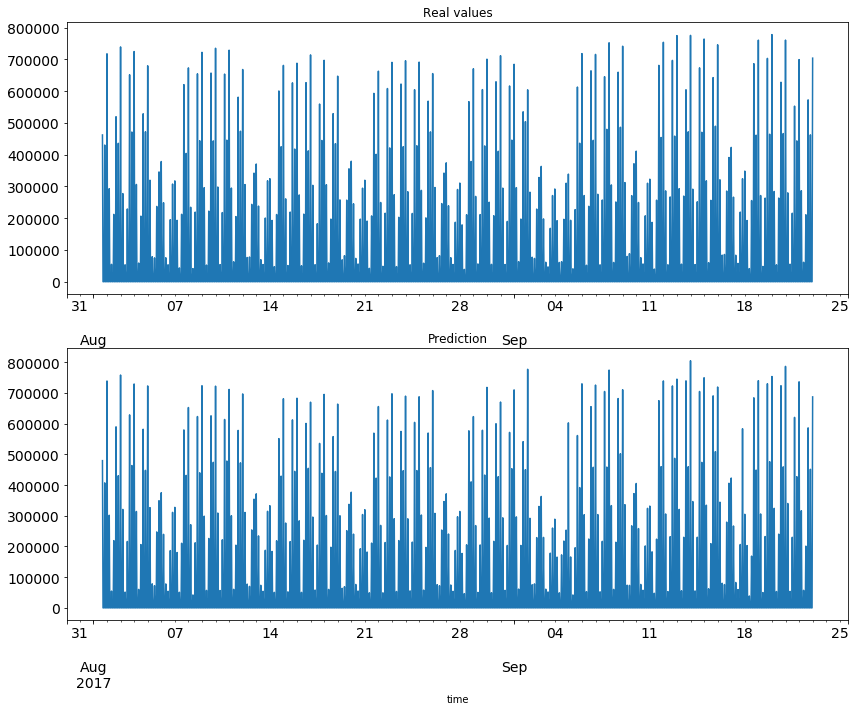

In [166]:
fig, axs = plt.subplots(2)
ss.delta_exits.plot(figsize=(14,11), title= 'Real values', fontsize=14, ax=axs[0])
ss.pred.plot(figsize=(14,11), title= 'Prediction', fontsize=14, ax=axs[1])
plt.show()

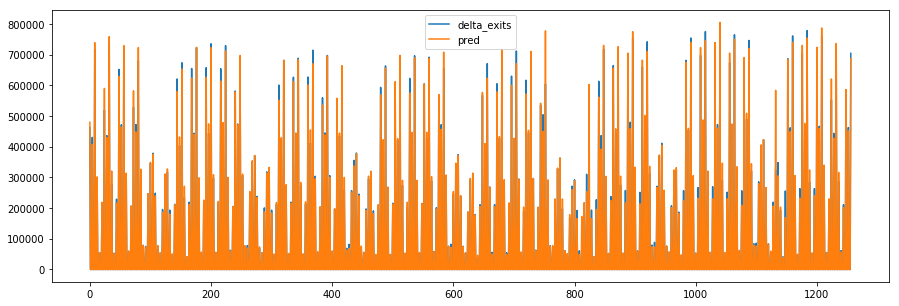

In [167]:
_ = ss2[['delta_exits','pred']].plot(figsize=(15, 5))

## Machine learning regressors: Resume

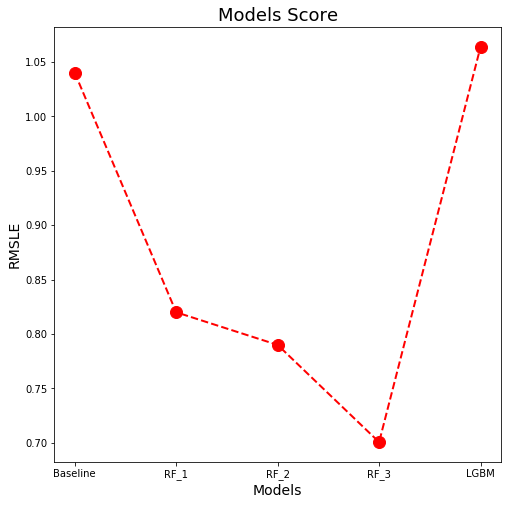

In [188]:
models=['Baseline','RF_1','RF_2','RF_3','LGBM']
models_erros = [1.04,0.82,0.79,0.7007,1.0639]
plt.figure(figsize=(8,8))
plt.plot(np.arange(5),models_erros,color='red', marker='o', linestyle='dashed',linewidth=2, markersize=12)
plt.xticks(np.arange(5), models)
plt.xlabel('Models',fontsize=14)
plt.ylabel('RMSLE',fontsize=14)
plt.title('Models Score',fontsize=18)
plt.show()

## 11. LSTM  <<<< NOT IMPLEMENTE >>> 

## 12. SARIMA, ARIMA  <<<< NOT IMPLEMENTED >>> 

## 13. Models comparsion and discussion

## Further improvements
    
    * Due to the lack of  time for resolving this chalenge (48h), was ano possible to optmize the regressores backtesting and neither the hypterparamter tunig (in the example as used a fixed set of hiperparameter);
    
    * Teste time other set of time-series based models;
    
    * Was verified on "Exploratory analysis", there is a considerable seasonality on weekly traffic distribuition. Therefore, we could generate clusters regarding the the business of each day of the week and turn it into a feature for possible boosting in performane;
    
    * For this models, events such as holidays would have a considerable impact on the predictions. So treatment for this kind of event could be added;
    
    
    * Adicitional feature with wether information would also be extreemaly valueble for the short-term predictions
    
    
    * Improve tuning of hyperameters on machine learning regressions classes